In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This script is focused on gastrulation data split into two section. In the first section we plot infividual features along with their posterior correlation distribution. In the next section we investigate the role of coverage and inflation in the discrepance between SCRaPL and Pearson correlations. 

In [ ]:
from IPython import display
import pandas as pd
import numpy as np
import numpy as np
import numpy.ma as ma
import scipy
import scipy.stats
from scipy.stats import gaussian_kde

from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib import cm
from matplotlib.colors import Normalize 
from matplotlib.offsetbox import AnchoredText

from tensorflow import keras
from sklearn.neighbors import KernelDensity

from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import pickle
from timeit import default_timer as timer

Load Data and prepare them for plotting

In [ ]:
Folder = '/content/drive/MyDrive/'
yy_met = pd.read_csv(Folder+'SCRaPL/Real/Data/Met.csv',sep=',',index_col=[0])
yy_exp = pd.read_csv(Folder+'SCRaPL/Real/Data/Rna.csv',sep=',',index_col=[0])
CpG = pd.read_csv(Folder+'SCRaPL/Real/Data/CpG.csv',sep=',',index_col=[0])
nrm = pd.read_csv(Folder+'SCRaPL/Real/Data/nrm_new.csv',sep=',',index_col=[1])

In [ ]:
y_met_np = yy_met.to_numpy()
y_exp_np = yy_exp.to_numpy()
CpG_np = CpG.to_numpy()

CpG_np[CpG_np ==0] = np.nan
y_met_np[np.isnan(CpG_np)] = np.nan
y_exp_np[np.isnan(CpG_np)] = np.nan

met_r = np.divide(y_met_np,CpG_np)
y_exp_nrm_np =  np.divide(y_exp_np,np.transpose(nrm.to_numpy()))

met_mask=ma.masked_invalid(met_r)
exp_mask=ma.masked_invalid(y_exp_nrm_np)
msk = (~met_mask.mask & ~exp_mask.mask)

crr_prs = []
for ii in range(9480):
    tt1 = met_r[ii,:]
    tt2 = y_exp_nrm_np[ii,:]
    tt_msk = msk[ii,:]
    crr_prs.append(ma.corrcoef(tt1[tt_msk],tt2[tt_msk])[0,1])

In [ ]:
with open(Folder+'SCRaPL/Real/Results_DIC_col/nuts_cor_gastr_dic_n.pickle', 'rb') as handle:
    post_cor = pickle.load(handle)

In [ ]:
eps = 0.0001
yy_met_rt = yy_met.div(CpG+eps)
yy_exp_nrm = np.log(1+yy_exp.div(nrm['norm_fact']))

In [ ]:
def density_scatter_plot(x, y,m_ln,c_ln, **kwargs):

    x_met,x_exp = x

    m_met,m_exp = m_ln
    c_met,c_exp = c_ln

    values_met = np.vstack((x_met, y))
    kernel_met = gaussian_kde(values_met)
    kde_met = kernel_met.evaluate(values_met)

    norm_met = Normalize(vmin=kde_met.min(), vmax=kde_met.max())
    colors_met = cm.ScalarMappable(norm=norm_met, cmap='viridis').to_rgba(kde_met)

    values_exp = np.vstack((x_exp, y))
    kernel_exp = gaussian_kde(values_exp)
    kde_exp = kernel_exp.evaluate(values_exp)

    norm_exp = Normalize(vmin=kde_exp.min(), vmax=kde_exp.max())
    colors_exp = cm.ScalarMappable(norm=norm_exp, cmap='viridis').to_rgba(kde_exp)

    kwargs['color'] = colors_met
    kwargs['color'] = colors_exp

    fig, ax = plt.subplots(1,2)
    im = ax[0].scatter(x_met,y,c=colors_met,label='Data')
    fig.colorbar(im, ax=ax[0])
    ax[0].plot(x_met, m_met*x_met + c_met, 'r', label="y = {}{}x".format(np.round_(c_met,decimals=2),np.round_(m_met,decimals=2)))
    ax[0].set_xlabel("CpG coverage (ln)",fontsize=20)
    ax[0].set_ylabel(r"ln(1+|$\bar{ρ_{j}}$-$\bar{ρ_{prs}}$|)",fontsize=20)
    ax[0].legend()
    ax[1].scatter(x_exp,y,c=colors_exp,label='Data')
    ax[1].plot(x_exp, m_exp*x_exp + c_exp, 'r', label="y = {}+{}x".format(np.round_(c_exp,decimals=2),np.round_(m_exp,decimals=2)))
    ax[1].set_xlabel("% zeros exp. (ln)",fontsize=20)
    ax[1].set_ylabel(r"ln(1+|$\bar{ρ_{j}}$-$\bar{ρ_{prs}}$|)",fontsize=20)
    ax[1].legend()

    plt.tight_layout()
def density_scatter_feature(x, y,cpg,cr_pst,prs,ft_ind, **kwargs):
    
    fig, ax = plt.subplots(1,2)
    im = ax[0].scatter(x,y,c=cpg)
    fig.colorbar(im, ax=ax[0])
    ax[0].set_xlabel("Raw Methylation", labelpad = 5,fontsize=20)
    ax[0].set_ylabel("Log Expression", labelpad = 5,fontsize=20)
    #plt.rcParams.update({'font.size': 20})
    anchored_text = AnchoredText("Prs. = {}".format(np.round_(prs,decimals=2)), loc=2)
    ax[0].add_artist(anchored_text)

    ax[1].violinplot(np.tanh(cr_pst/2),showmeans=True)
    ax[1].set_xlabel(ft_ind, labelpad = 5,fontsize=20)
    ax[1].set_ylabel("Posterior Correlation", labelpad = 5,fontsize=20)
    ax[1].set_xticklabels([])
    plt.tight_layout()
    #plt.show()  


Plot individual features

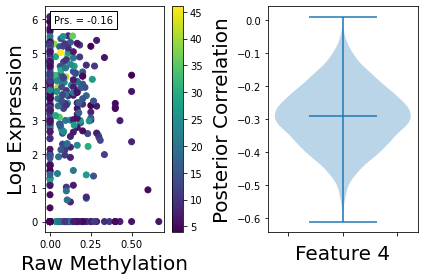

In [ ]:
aaa=60 #8800#188#1949#1857#1824#1210# #EFDR and FDR important example     

x = yy_met_rt.iloc[aaa,:].to_numpy()
y = yy_exp_nrm.iloc[aaa,:].to_numpy()

cpg = CpG.iloc[aaa,:].to_numpy()
cr = post_cor[:,aaa].numpy()

density_scatter_feature(x, y,cpg,cr,crr_prs[aaa],"Feature {}".format(aaa+1))
#plt.savefig(Folder+'SCRaPL/Real/Gastr_ft_'+str(aaa+1)+'_eifi.pdf')
plt.show()

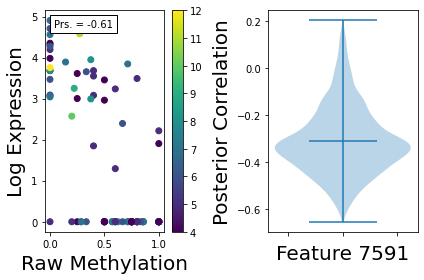

In [ ]:
aaa =7590 #4#2723#1385#1052#  #EFDR not important, FDR important example   

x = yy_met_rt.iloc[aaa,:].to_numpy()
y = yy_exp_nrm.iloc[aaa,:].to_numpy()

cpg = CpG.iloc[aaa,:].to_numpy()
cr = post_cor[:,aaa].numpy()

density_scatter_feature(x, y,cpg,cr,crr_prs[aaa],"Feature {}".format(aaa+1))
#plt.savefig(Folder+'SCRaPL/Real/Gastr_ft_'+str(aaa+1)+'_enfi.pdf')
plt.show()

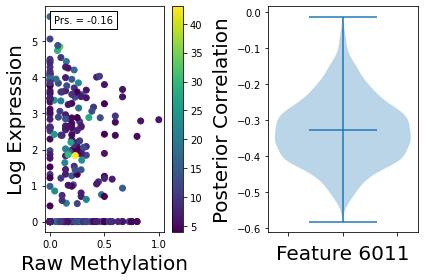

In [ ]:
aaa = 6010#4138#1231#414#3 #6010#433 #EFDR important, FDR not important example      
x = yy_met_rt.iloc[aaa,:].to_numpy()
y = yy_exp_nrm.iloc[aaa,:].to_numpy()

cpg = CpG.iloc[aaa,:].to_numpy()
cr = post_cor[:,aaa].numpy()

density_scatter_feature(x, y,cpg,cr,crr_prs[aaa],"Feature {}".format(aaa+1))
#plt.savefig(Folder+'SCRaPL/Real/Gastr_ft_'+str(aaa+1)+'_eifn.pdf')
plt.show()

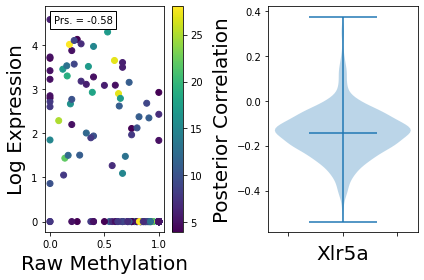

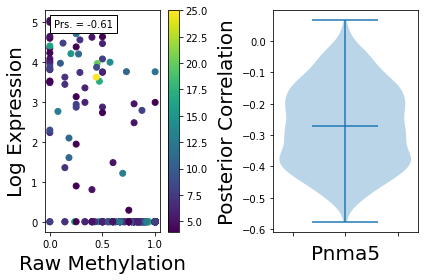

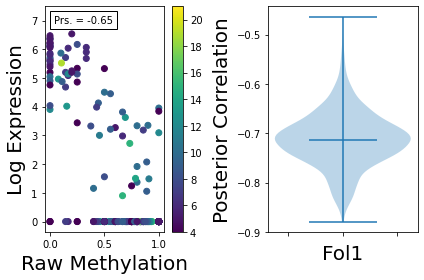

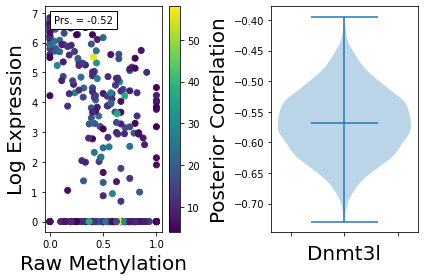

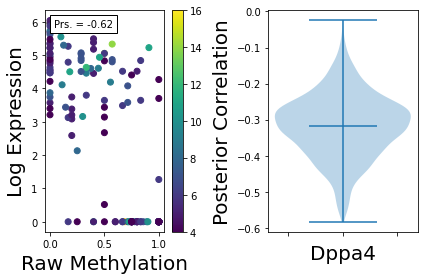

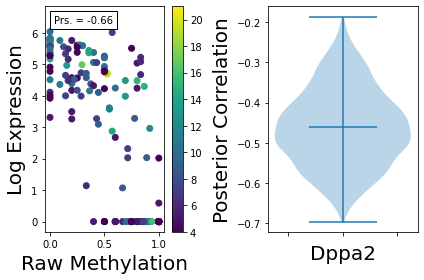

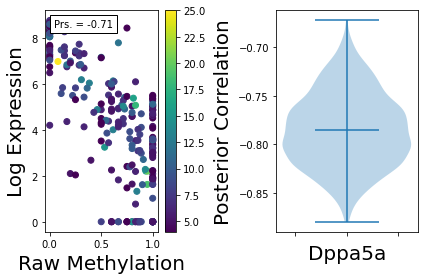

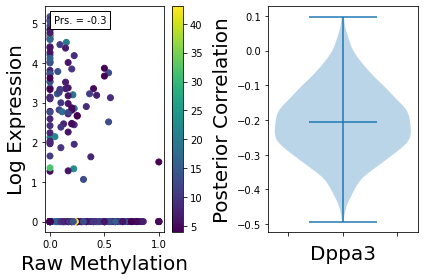

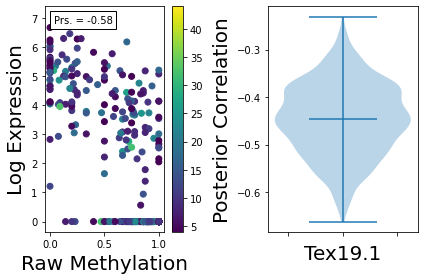

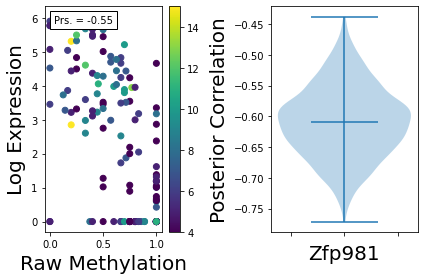

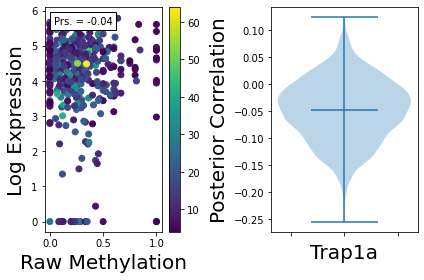

In [ ]:
#Features documented in literature for their biological importance 
aaa = [8390,7868,189,61,8406,9100,8528,7539,6671,8261,7923]
gene_name = ["Xlr5a","Pnma5","Fol1","Dnmt3l","Dppa4","Dppa2","Dppa5a", "Dppa3","Tex19.1","Zfp981","Trap1a"]
for ii in range(len(aaa)):

  x = yy_met_rt.iloc[aaa[ii]-1,:].to_numpy()
  y = yy_exp_nrm.iloc[aaa[ii]-1,:].to_numpy()

  cpg = CpG.iloc[aaa[ii]-1,:].to_numpy()
  cr = post_cor[:,aaa[ii]-1].numpy()

  density_scatter_feature(x, y,cpg,cr,crr_prs[aaa[ii]-1],gene_name[ii])
  #plt.savefig(Folder+'SCRaPL/Real/'+gene_name[ii]+'.pdf')
  plt.show()


In [ ]:
aaa = [3,19,21,43,60,87,140,158,160,188,195,212,268,308,324,333,397,414,433,477,503,510,743,883,900,969,1007,1025,1133,1146,1172,1207,
       1210,1231,1356,1359,1405,1413,1452,1483,1530,1549]
for ii in range(len(aaa)):

  x = yy_met_rt.iloc[aaa[ii],:].to_numpy()
  y = yy_exp_nrm.iloc[aaa[ii],:].to_numpy()

  cpg = CpG.iloc[aaa[ii],:].to_numpy()
  cr = post_cor[:,aaa[ii]].numpy()

  density_scatter_feature(x, y,cpg,cr,crr_prs[aaa[ii]],"Feature {}".format(aaa[ii]+1))
  #plt.savefig(Folder+'SCRaPL/Real/'+gene_name[ii]+'.pdf')
  plt.show()


Output hidden; open in https://colab.research.google.com to view.

Investigate the impact of coverage and zero inflation in the discrepancy between SCRaPL's posterior mean and Pearson correlation. This is done by regressing average feature coverage and expression's observed zeros against the correlation discrepancy.

In [ ]:
post_cor_mn = tf.reduce_mean(tf.tanh(post_cor/2),axis=0).numpy()
cpg_mn = np.nanmean(CpG_np,axis=1)
zrs_exp = np.nanmean(y_exp_nrm_np==0,axis=1)

y = np.log(1+np.abs(post_cor_mn-crr_prs))
x_met = np.log(1+cpg_mn)
x_exp = np.log(1+zrs_exp)

xx_met_min = np.min(x_met)
xx_met_max = np.max(x_met)
xx_met = np.linspace(xx_met_min,xx_met_max,num=100)

xx_exp_min = np.min(x_exp)
xx_exp_max = np.max(x_exp)
xx_exp = np.linspace(xx_exp_min,xx_exp_max,num=100)

In [ ]:
A_met =  np.hstack([np.ones_like(x_met[:,np.newaxis]),x_met[:,np.newaxis]])
A_exp =  np.hstack([np.ones_like(x_exp[:,np.newaxis]),x_exp[:,np.newaxis]])
c_met,m_met = np.linalg.lstsq(A_met, np.transpose(y), rcond=None)[0]
c_exp,m_exp = np.linalg.lstsq(A_exp, np.transpose(y), rcond=None)[0]

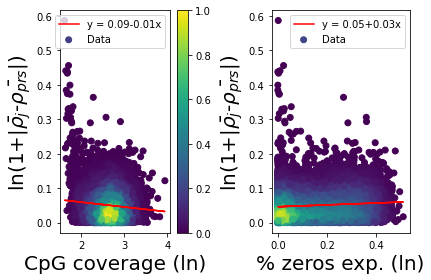

In [ ]:
density_scatter_plot([x_met,x_exp],y,[m_met,m_exp],[c_met,c_exp])
#plt.savefig(Folder+'SCRaPL/Real/Paper_Analysis/scatter_check_cpg.pdf')